In [13]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import pickle
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import gc
import re

In [15]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1')

#removing @username from the text column

df[6] = df.iloc[:, 5].apply(lambda text: re.sub(r'@\w+\s*', '', text))
df.head()

In [18]:
#save the new text column to two txt files (one for positive sentences and one for negative sentences)

df[df.iloc[:, 0]==4].iloc[:, 6].to_csv('pos1.txt', index=False, header=False)
df[df.iloc[:, 0]==0].iloc[:, 6].to_csv('neg1.txt', index=False, header=False)

In [20]:
# combine the old pos.txt and the new pos1.txt

with open('pos.txt', 'r', encoding='utf-8') as file1:
    file1_contents = file1.read()

with open('pos1.txt', 'r', encoding='utf-8') as file2:
    file2_contents = file2.read()

combined_contents = file1_contents + file2_contents
# Open the output file in write mode (creates the file if it doesn't exist)
with open('pos_all.txt', 'w', encoding='utf-8') as combined_file:
    combined_file.write(combined_contents)

In [21]:
# combine the old neg.txt and the new neg1.txt

with open('neg.txt', 'r', encoding='utf-8') as file1:
    file1_contents = file1.read()

with open('neg1.txt', 'r', encoding='utf-8') as file2:
    file2_contents = file2.read()

combined_contents = file1_contents + file2_contents
# Open the output file in write mode (creates the file if it doesn't exist)
with open('neg_all.txt', 'w', encoding='utf-8') as combined_file:
    combined_file.write(combined_contents)

In [27]:
def create_lexicon (directory=os.getcwd(), max_quant=0.998, min_quant=0.972, visualize=False):
    
    all_words = []
    lemmatizer = WordNetLemmatizer()

    for filename in os.listdir(directory):
        if filename.endswith('_all.txt'):
            with open(filename, 'r', encoding='utf-8') as file:
                for line in file:
                    words_in_line = word_tokenize(line)
                    all_words += words_in_line
        
    all_words_lem = [lemmatizer.lemmatize(word) for word in all_words]
    all_words_cnt = Counter(all_words_lem)
    
    freq_list = [freq for _ , freq in all_words_cnt.items()]
    max_freq = np.quantile(freq_list, max_quant)
    min_freq = np.quantile(freq_list, min_quant)

    all_words_filt = {word : freq for word, freq in all_words_cnt.items() if  min_freq < freq < max_freq}
    freq_list_filt = [freq for _ , freq in all_words_filt.items()]
    words_list_filt = [word for word , _ in all_words_filt.items()]
    
    if visualize:
        print ('number of words in the filtered dictionary:', len(freq_list_filt))
        print ('max repetitions considered:', max_freq)
        print ('min repetitions considered:', min_freq)
        plt.hist(freq_list_filt, bins = len(freq_list_filt))
        plt.show()
    
    return words_list_filt

number of words in the filtered dictionary: 13677
max repetitions considered: 1928.0
min repetitions considered: 50.0


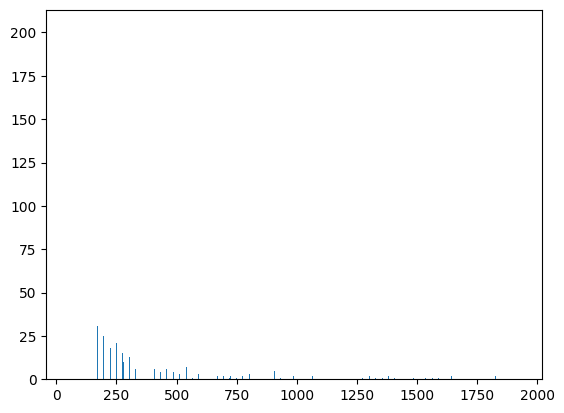

['destined',
 '21st',
 'century',
 'conan',
 'splash',
 'greater',
 'van',
 'steven',
 'lord',
 'ring',
 'column',
 'describe',
 'peter',
 'jackson',
 'vision',
 'j',
 'effective',
 'rare',
 'honest',
 'provides',
 'insight',
 'comic',
 'reached',
 'absolute',
 'offer',
 'combination',
 'entertainment',
 'education',
 'perhaps',
 'literally',
 'showed',
 'intention',
 'screenplay',
 'curl',
 'edge',
 'clever',
 'somehow',
 'pull',
 'slice',
 'asian',
 'cinema',
 'singing',
 'surprise',
 'quality',
 'genuine',
 'fed',
 'greatest',
 'ultimately',
 'utterly',
 'compelling',
 'wrote',
 'reputation',
 'famous',
 'author',
 'lived',
 'overly',
 'documentary',
 'masterpiece',
 'four',
 'beauty',
 'willing',
 'mystery',
 'breath',
 'fresh',
 'thoughtful',
 'cast',
 'includes',
 'actor',
 'independent',
 'involves',
 'amusing',
 'disturbing',
 'assembly',
 'whom',
 'connect',
 'departure',
 'standard',
 'fare',
 'score',
 'dedicated',
 'occasionally',
 'extremely',
 'brings',
 'romantic',
 '95'

In [26]:
# create_lexicon(visualize=True)

In [33]:
def create_dataframe (lexicon, sample, is_positive):
    
    lemmatizer = WordNetLemmatizer()
    dataset = []
    label = 1 if is_positive else 0
    
    with open(sample, 'r', encoding='utf-8') as file:
        for line in file:
            line_tokenized = word_tokenize(line)
            line_lemmatized = [lemmatizer.lemmatize(line_tokenized) for line_tokenized in line_tokenized]
            feature = np.zeros(len(lexicon))
            
            for word in line_lemmatized:
                if word in lexicon:
                    feature[lexicon.index(word)] += 1
                    
            dataset.append([feature, label])
        
        dataframe = pd.DataFrame(dataset, columns=['text_encod', 'label']) # .reset_index(drop = True)

    return dataframe

In [34]:
def merge_n_split_df(pos_file, neg_file):
    
    lexicon = create_lexicon()
    print('lexicon created')
    
    pos_df = create_dataframe(lexicon, pos_file, is_positive = True)
    print('positive dataframe created')
    neg_df = create_dataframe(lexicon, neg_file, is_positive = False)
    print('negative dataframe created')
    full_dataframe = pd.concat([pos_df, neg_df]) #, ignore_index = True
    print('full dataframe created')    
    
    train_x, test_x, train_y, test_y  = train_test_split(full_dataframe['text_encod'], full_dataframe['label'], 
                                                        test_size=0.1, shuffle=True)
    print('train test split created')    

    return train_x, test_x, train_y, test_y

In [ ]:
# if __name__ == '__main__':

train_x, test_x, train_y, test_y = merge_n_split_df(pos_file = 'pos_all.txt', neg_file = 'neg_all.txt')
with open('sentiment_set.pickle','wb') as file:
    pickle.dump([train_x,test_x,train_y,test_y],file)
    print('sentiment_set pickle created')

lexicon created
positive dataframe created


In [12]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=2000, 
                                activation='relu', 
                                input_shape=(train_x.iloc[0].shape), # number of words in the lexicon (to reshape accordingly)
                                kernel_initializer='glorot_uniform')) #uniform distribution weights initialization
print(train_x[0].shape)
model.add(tf.keras.layers.Dense(4000))
# model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(8000))
# model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(16000))
model.add(tf.keras.layers.Dense(2, activation='softmax')) # 2 (pos or neg) output (to one-hot encode accordingly)
model.summary()

(481,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 2000)              964000    
                                                                 
 dense_5 (Dense)             (None, 4000)              8004000   
                                                                 
 dense_6 (Dense)             (None, 8000)              32008000  
                                                                 
 dense_7 (Dense)             (None, 16000)             128016000 
                                                                 
 dense_8 (Dense)             (None, 2)                 32002     
                                                                 
Total params: 169,024,002
Trainable params: 169,024,002
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(loss='categorical_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

early_stopping_monitor = EarlyStopping(monitor='accuracy', patience=3)

x_train_resh = np.vstack(train_x)
y_train_resh = to_categorical(train_y, num_classes=2)

history = model.fit(x_train_resh,
                    y_train_resh,
                    epochs=50,
                    batch_size = 100,
                    callbacks=[early_stopping_monitor])

Epoch 1/50
96/96 [==============================] - 5s 46ms/step - loss: 5.0243 - accuracy: 0.5265 - precision_1: 0.5266 - recall_1: 0.5264
Epoch 2/50
96/96 [==============================] - 5s 49ms/step - loss: 0.5731 - accuracy: 0.7013 - precision_1: 0.7013 - recall_1: 0.7013
Epoch 3/50
96/96 [==============================] - 5s 51ms/step - loss: 0.3738 - accuracy: 0.8286 - precision_1: 0.8286 - recall_1: 0.8286
Epoch 4/50
96/96 [==============================] - 5s 51ms/step - loss: 0.1943 - accuracy: 0.9187 - precision_1: 0.9187 - recall_1: 0.9187
Epoch 5/50
96/96 [==============================] - 5s 52ms/step - loss: 0.1345 - accuracy: 0.9450 - precision_1: 0.9450 - recall_1: 0.9450
Epoch 6/50
96/96 [==============================] - 5s 52ms/step - loss: 0.1061 - accuracy: 0.9537 - precision_1: 0.9537 - recall_1: 0.9537
Epoch 7/50
96/96 [==============================] - 5s 52ms/step - loss: 0.1006 - accuracy: 0.9571 - precision_1: 0.9571 - recall_1: 0.9571
Epoch 8/50
96/96 [==

In [14]:
y_pred_perc = model(np.vstack(test_x))
y_pred = tf.argmax(y_pred_perc, axis = 1)
y_test = [1 if y == [0, 1] else 0 for y in test_y]
test_acc = np.mean(y_pred==y_test)
test_acc

0.5276476101218369

In [9]:
model1 = tf.keras.models.Sequential()
model1.add(tf.keras.layers.Dense(units=10000, 
                                activation='relu', 
                                input_shape=(train_x.iloc[0].shape), # number of words in the lexicon (to reshape accordingly)
                                kernel_initializer='glorot_uniform')) #uniform distribution weights initialization
print(train_x[0].shape)
model1.add(tf.keras.layers.Dense(10000))
model1.add(tf.keras.layers.Dense(10000))
model1.add(tf.keras.layers.Dense(2, activation='softmax')) # 2 (pos or neg) output (to one-hot encode accordingly)
model1.summary()

(481,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10000)             4820000   
                                                                 
 dense_1 (Dense)             (None, 10000)             100010000 
                                                                 
 dense_2 (Dense)             (None, 10000)             100010000 
                                                                 
 dense_3 (Dense)             (None, 2)                 20002     
                                                                 
Total params: 204,860,002
Trainable params: 204,860,002
Non-trainable params: 0
_________________________________________________________________


In [10]:
model1.compile(loss='categorical_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(), 
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

early_stopping_monitor = EarlyStopping(monitor='accuracy', patience=3)

x_train_resh = np.vstack(train_x)
y_train_resh = to_categorical(train_y, num_classes=2)

history = model1.fit(x_train_resh,
                    y_train_resh,
                    epochs=50,
                    batch_size = 1000,
                    callbacks=[early_stopping_monitor])

Epoch 1/50
10/10 [==============================] - 4s 263ms/step - loss: 11.3279 - accuracy: 0.5046 - precision: 0.5045 - recall: 0.5029
Epoch 2/50
10/10 [==============================] - 3s 265ms/step - loss: 0.9423 - accuracy: 0.5002 - precision: 0.5002 - recall: 0.5002
Epoch 3/50
10/10 [==============================] - 3s 263ms/step - loss: 0.7073 - accuracy: 0.5213 - precision: 0.5213 - recall: 0.5213
Epoch 4/50
10/10 [==============================] - 3s 265ms/step - loss: 0.7021 - accuracy: 0.5301 - precision: 0.5301 - recall: 0.5301
Epoch 5/50
10/10 [==============================] - 3s 267ms/step - loss: 0.6545 - accuracy: 0.5929 - precision: 0.5929 - recall: 0.5929
Epoch 6/50
10/10 [==============================] - 3s 268ms/step - loss: 0.6041 - accuracy: 0.7234 - precision: 0.7234 - recall: 0.7234
Epoch 7/50
10/10 [==============================] - 3s 269ms/step - loss: 0.5294 - accuracy: 0.7594 - precision: 0.7594 - recall: 0.7594
Epoch 8/50
10/10 [======================

In [11]:
y_pred_perc1 = model1(np.vstack(test_x))
y_pred1 = tf.argmax(y_pred_perc1, axis = 1)
y_test1 = [1 if y == [0, 1] else 0 for y in test_y]
test_acc1 = np.mean(y_pred1==y_test1)
test_acc1

0.5135895032802249

In [22]:
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Dense(units=1000, 
                                activation='relu', 
                                input_shape=(train_x.iloc[0].shape), # number of words in the lexicon (to reshape accordingly)
                                kernel_initializer='glorot_uniform')) #uniform distribution weights initialization
print(train_x[0].shape)
model2.add(tf.keras.layers.Dense(1000))
model2.add(tf.keras.layers.Dense(1000))
model2.add(tf.keras.layers.Dense(1000))
model2.add(tf.keras.layers.Dense(1000))
model2.add(tf.keras.layers.Dense(2, activation='softmax')) # 2 (pos or neg) output (to one-hot encode accordingly)
model2.summary()

(481,)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 1000)              482000    
                                                                 
 dense_24 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_25 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_26 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_27 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_28 (Dense)            (None, 2)                 2002      
                                                                 
Total params: 4,488,002
Trainable params: 4,488

In [23]:
model2.compile(loss='categorical_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(), 
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

early_stopping_monitor = EarlyStopping(monitor='accuracy', patience=3)

x_train_resh = np.vstack(train_x)
y_train_resh = to_categorical(train_y, num_classes=2)

history = model2.fit(x_train_resh,
                    y_train_resh,
                    epochs=50,
                    # batch_size = 1000,
                    callbacks=[early_stopping_monitor])

Epoch 1/50
300/300 [==============================] - 2s 6ms/step - loss: 0.6556 - accuracy: 0.6323 - precision_2: 0.6323 - recall_2: 0.6323
Epoch 2/50
300/300 [==============================] - 1s 5ms/step - loss: 0.5384 - accuracy: 0.7316 - precision_2: 0.7316 - recall_2: 0.7316
Epoch 3/50
300/300 [==============================] - 2s 5ms/step - loss: 0.4215 - accuracy: 0.7992 - precision_2: 0.7992 - recall_2: 0.7992
Epoch 4/50
300/300 [==============================] - 2s 5ms/step - loss: 0.2392 - accuracy: 0.8903 - precision_2: 0.8903 - recall_2: 0.8903
Epoch 5/50
300/300 [==============================] - 2s 5ms/step - loss: 0.1470 - accuracy: 0.9322 - precision_2: 0.9322 - recall_2: 0.9322
Epoch 6/50
300/300 [==============================] - 2s 5ms/step - loss: 0.1135 - accuracy: 0.9490 - precision_2: 0.9490 - recall_2: 0.9490
Epoch 7/50
300/300 [==============================] - 2s 5ms/step - loss: 0.0906 - accuracy: 0.9549 - precision_2: 0.9549 - recall_2: 0.9549
Epoch 8/50
30

In [26]:
y_pred_perc2 = model2(np.vstack(test_x))
y_pred2 = tf.argmax(y_pred_perc2, axis = 1)
y_test2 = [0 if y == [0, 1] else 1 for y in test_y]
test_acc2 = np.mean(y_pred2==y_test2)
test_acc2

0.5567010309278351

In [20]:
gc.collect()

4924